In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="whitegrid")


In [7]:
# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Display the first five rows
styled_df = df.head().style.set_properties(**{
    "background-color": "#254E58", 
    "color": "#e9c46a", 
    "border": "1.5px solid black"
}).set_table_styles([
    {"selector": "th", "props": [("color", 'white'), ("background-color", "#333333")]}
])
styled_df


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.000000,0,1,never,25.190000,6.600000,140,0
1,Female,54.000000,0,0,No Info,27.320000,6.600000,80,0
2,Male,28.000000,0,0,never,27.320000,5.700000,158,0
3,Female,36.000000,0,0,current,23.450000,5.000000,155,0
4,Male,76.000000,1,1,current,20.140000,4.800000,155,0


In [9]:
rows, cols = df.shape
print(f"Number of Rows: {rows}")
print(f"Number of Columns: {cols}")


Number of Rows: 100000
Number of Columns: 9


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [11]:
df.isnull().sum()


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [33]:
styled_desc = df.describe().style.format({
    'age': '{:.2f}',
    'hypertension': '{:.3f}',
    'heart_disease': '{:.3f}',
    'bmi': '{:.2f}',
    'HbA1c_level': '{:.2f}',
    'blood_glucose_level': '{:.2f}',
    'diabetes': '{:.3f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#111'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'left'), ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
]).set_properties(**{
    'font-size': '14px', 
    'background-color': '#5555', 
    'border-collapse': 'collapse', 
    'margin': '10px'
})
styled_desc

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.00,100000.000,100000.000,100000.00,100000.00,100000.00,100000.000
mean,41.89,0.075,0.039,27.32,5.53,138.06,0.085
std,22.52,0.263,0.195,6.64,1.07,40.71,0.279
min,0.08,0.000,0.000,10.01,3.50,80.00,0.000
25%,24.00,0.000,0.000,23.63,4.80,100.00,0.000
50%,43.00,0.000,0.000,27.32,5.80,140.00,0.000
75%,60.00,0.000,0.000,29.58,6.20,159.00,0.000
max,80.00,1.000,1.000,95.69,9.00,300.00,1.000


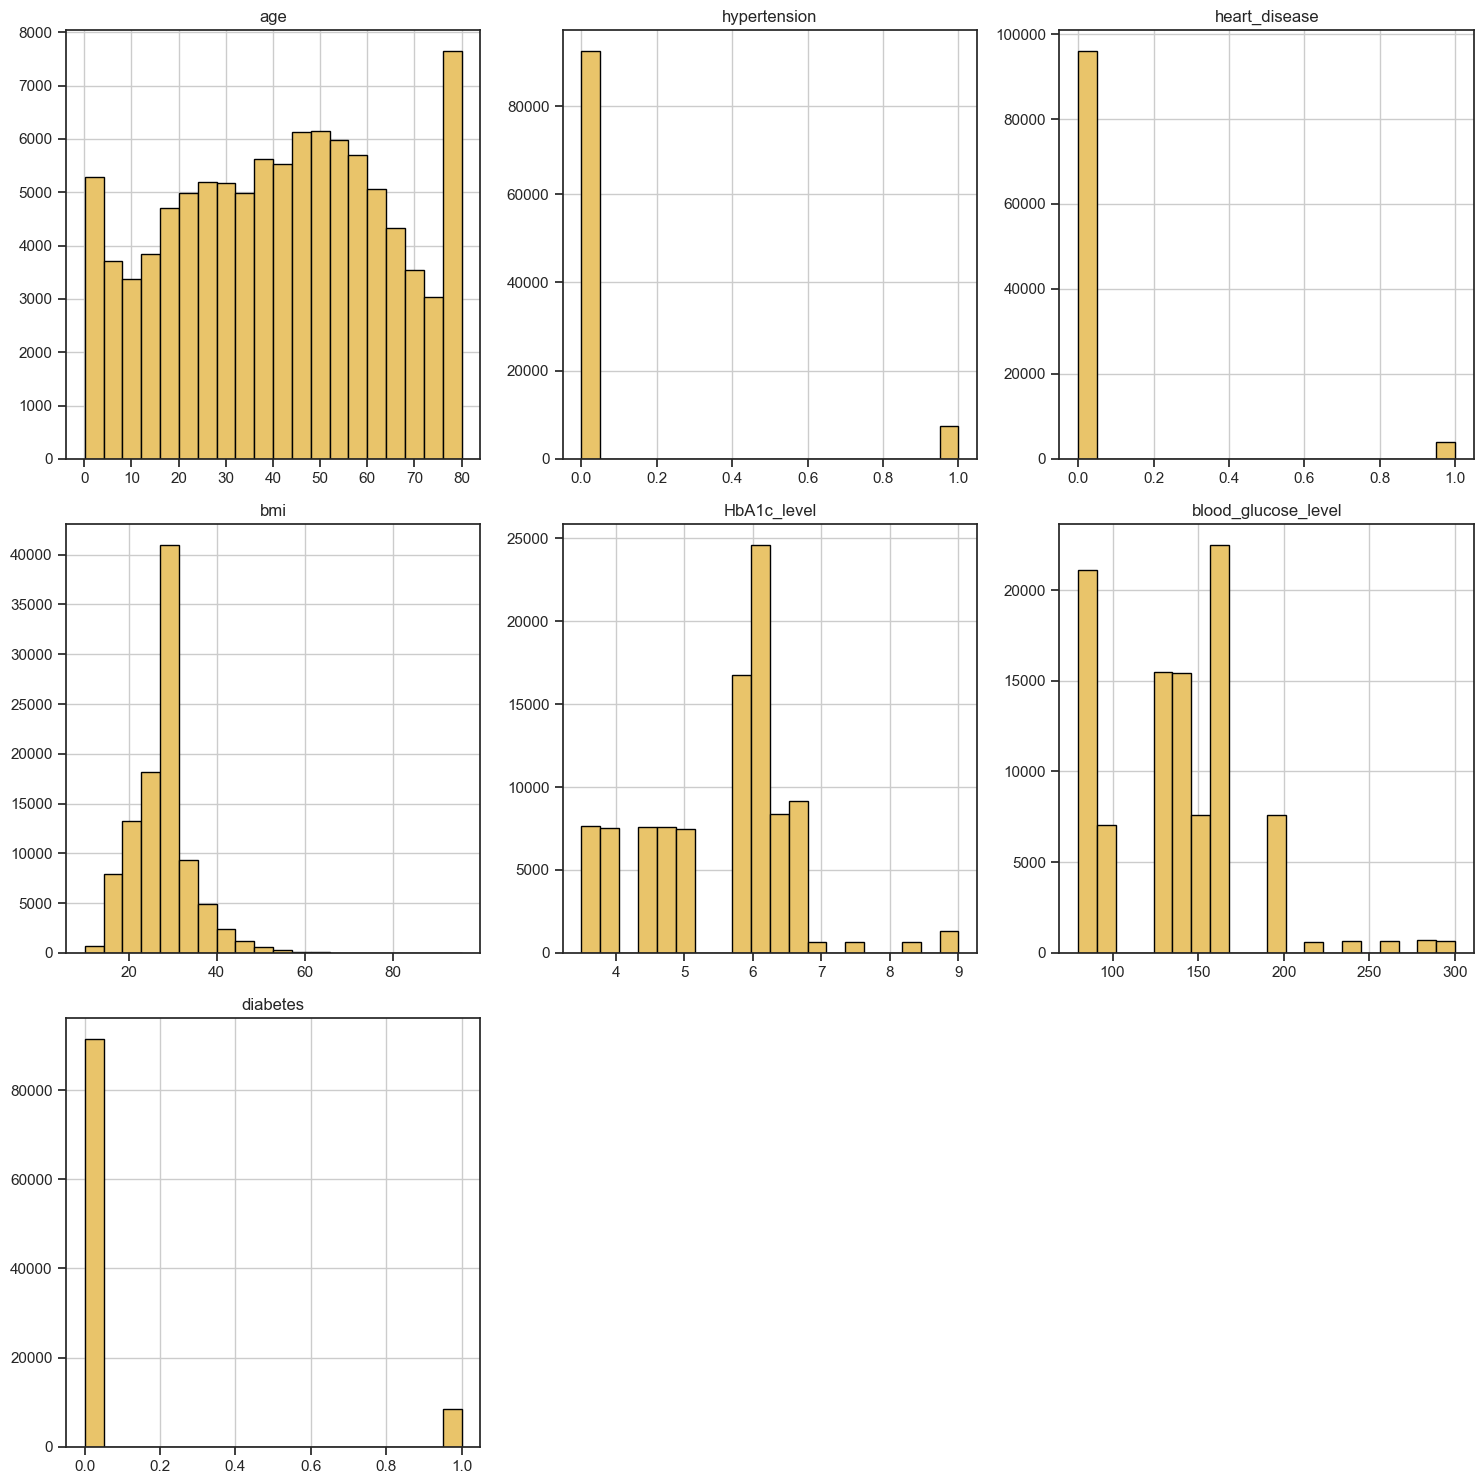

In [53]:
df.hist(figsize=(15, 15), bins=20, color='#e9c46a', edgecolor='black')
plt.tight_layout()
plt.show()


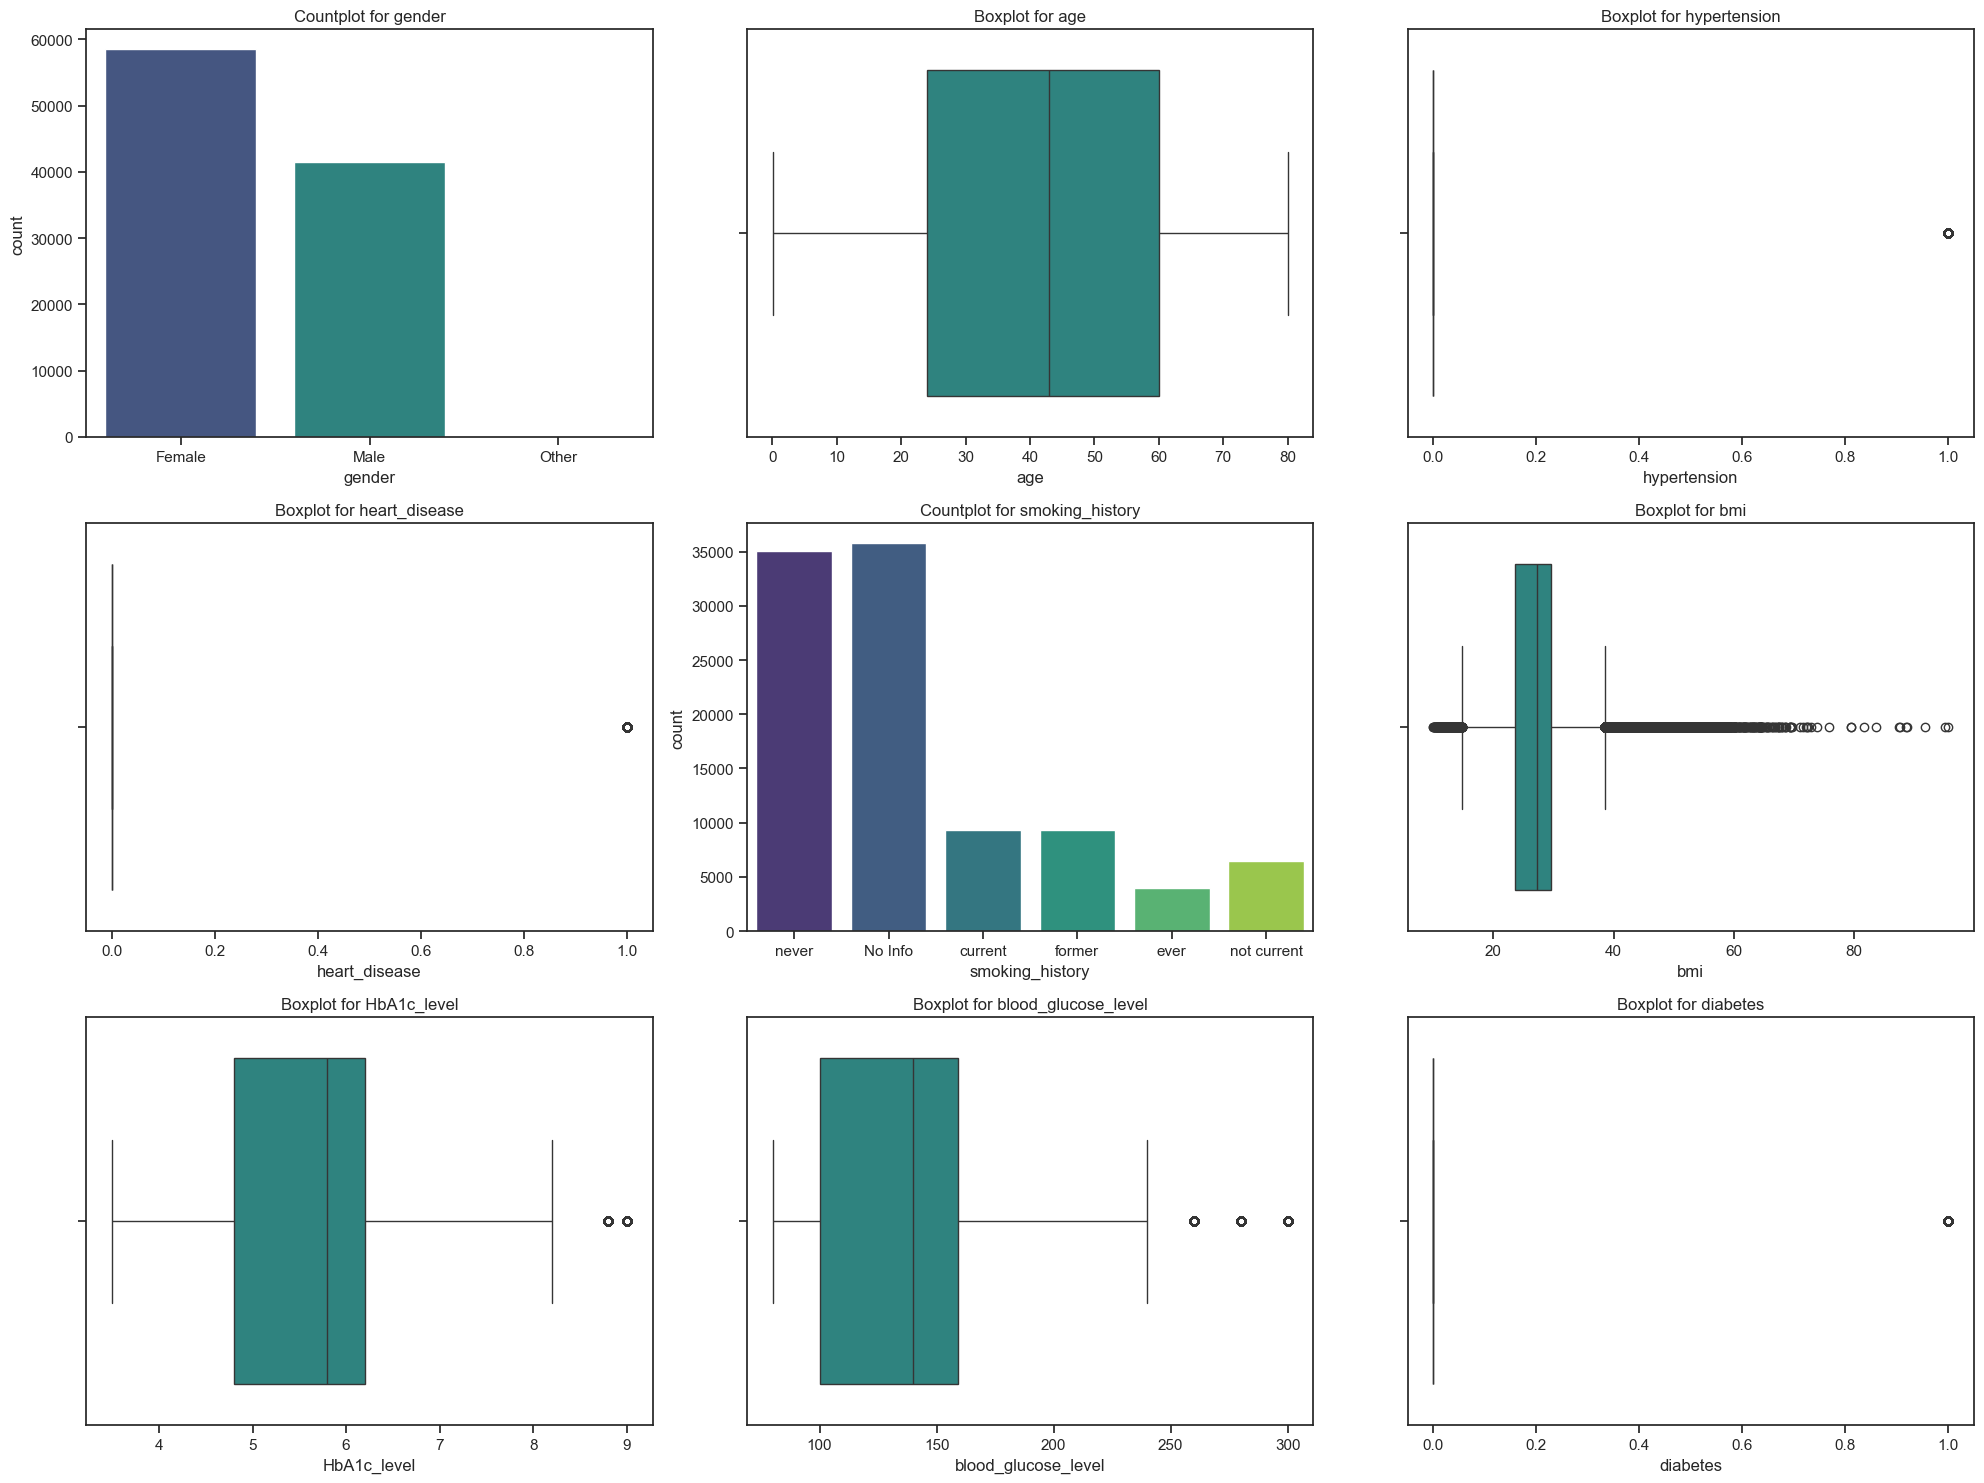

In [54]:
num_rows, num_cols = 3, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    if df[column].dtype in ['int64', 'float64']:
        sns.boxplot(data=df, x=column, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Boxplot for {column}')
    else:
        sns.countplot(data=df, x=column, ax=axes[i], palette="viridis")
        axes[i].set_title(f'Countplot for {column}')

plt.tight_layout()
plt.show()


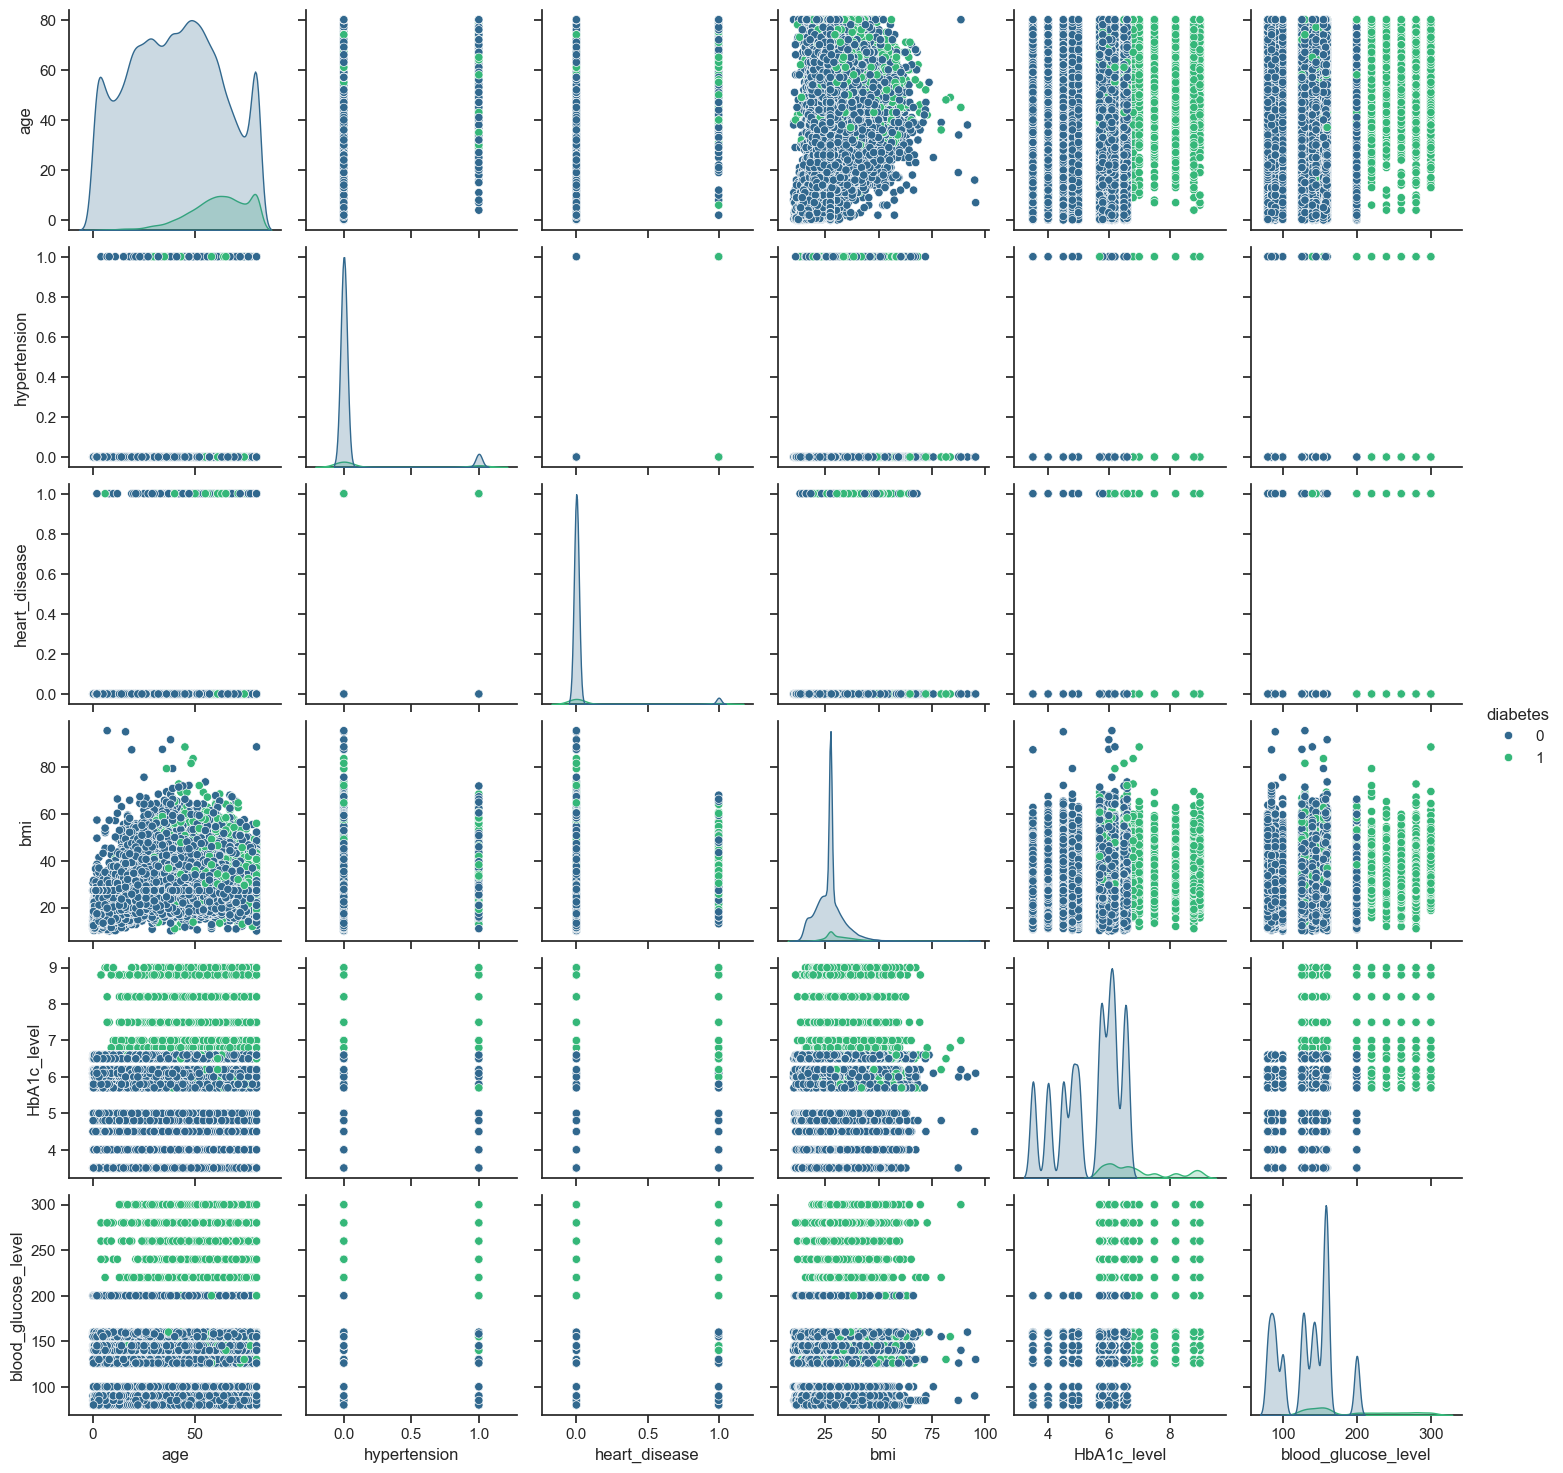

In [55]:
sns.pairplot(df, hue='diabetes', palette='viridis')
plt.show()


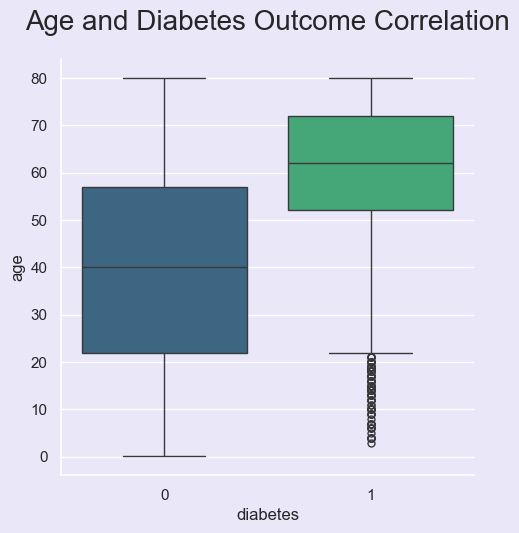

In [56]:
sns.set(rc={"axes.facecolor":"#EAE7F9","figure.facecolor":"#EAE7F9"})
sns.catplot(x="diabetes", y="age", data=df, kind='box', palette='viridis')
plt.title("Age and Diabetes Outcome Correlation", size=20, y=1.05)
plt.show()


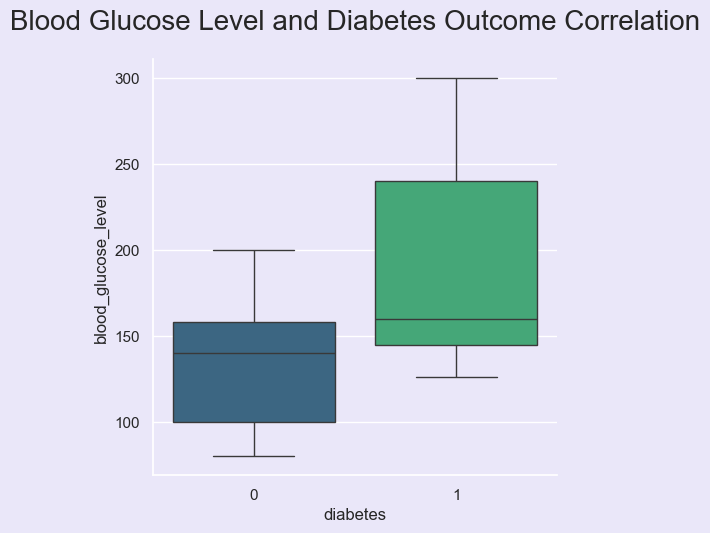

In [57]:
sns.catplot(x="diabetes", y="blood_glucose_level", data=df, kind='box', palette='viridis')
plt.title("Blood Glucose Level and Diabetes Outcome Correlation", size=20, y=1.05)
plt.show()


Data types after encoding:
gender                           int32
age                            float64
hypertension                     int64
heart_disease                    int64
bmi                            float64
HbA1c_level                    float64
blood_glucose_level              int64
diabetes                         int64
smoking_history_current           bool
smoking_history_ever              bool
smoking_history_former            bool
smoking_history_never             bool
smoking_history_not current       bool
dtype: object


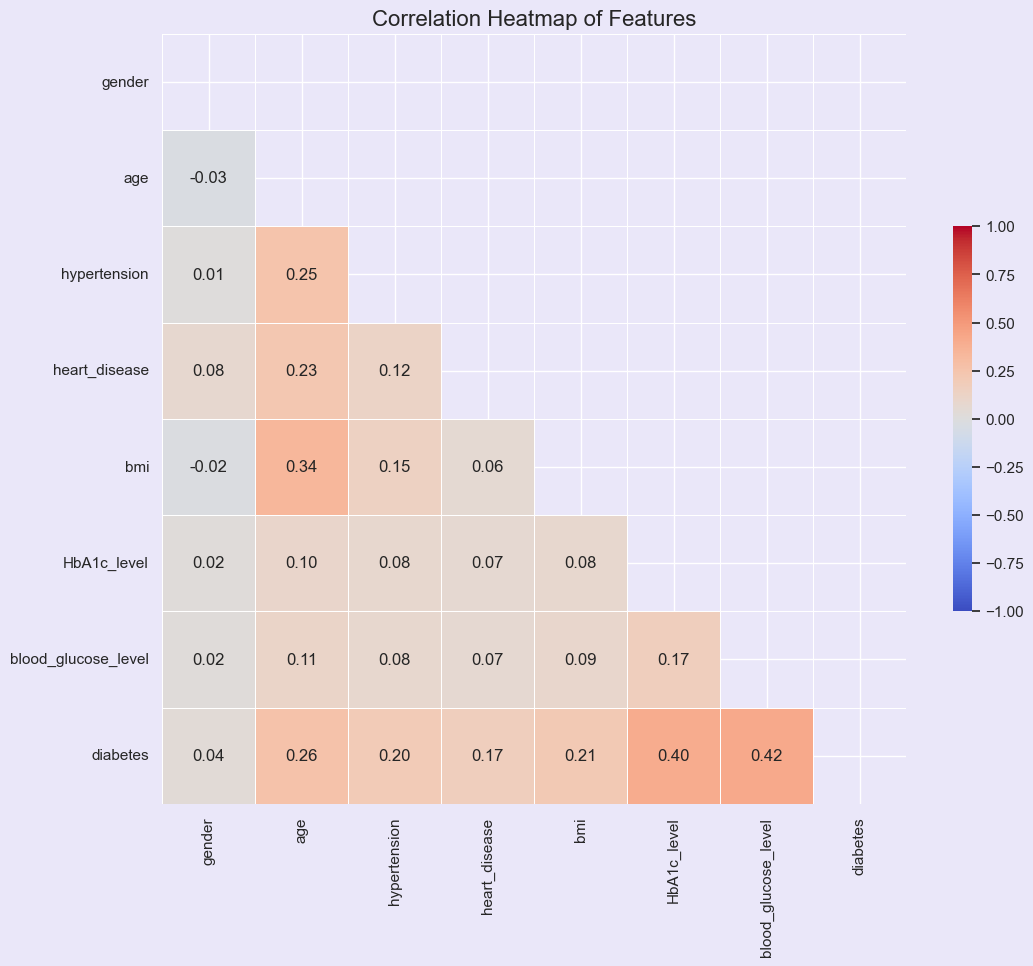

Features with high correlation to diabetes:
age                    0.258008
bmi                    0.214357
HbA1c_level            0.400660
blood_glucose_level    0.419558
diabetes               1.000000
Name: diabetes, dtype: float64


In [63]:

# Encode 'gender' using LabelEncoder
if df['gender'].dtype == 'object':
    le = LabelEncoder()
    df['gender'] = le.fit_transform(df['gender'])

# One-Hot Encode 'smoking_history' using pd.get_dummies
if 'smoking_history' in df.columns and df['smoking_history'].dtype == 'object':
    df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# Verify that all columns are now numeric
print("Data types after encoding:")
print(df.dtypes)

# Step 2: Compute and Plot the Correlation Heatmap

# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            vmax=1.0, 
            vmin=-1.0, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

# Identify and print features with high correlation to diabetes
high_corr_threshold = 0.2
high_corr = corr_matrix['diabetes'][abs(corr_matrix['diabetes']) > high_corr_threshold]
print("Features with high correlation to diabetes:")
print(high_corr)



In [64]:
print("Standard Deviation of Numerical Features:")
print(df[['age', 'hypertension', 'heart_disease', 'blood_glucose_level', 'bmi', 'HbA1c_level']].std())


Standard Deviation of Numerical Features:
age                    22.516840
hypertension            0.263150
heart_disease           0.194593
blood_glucose_level    40.708136
bmi                     6.636783
HbA1c_level             1.070672
dtype: float64


In [65]:
# Define numerical columns for outlier treatment
numeric_columns = ['blood_glucose_level', 'HbA1c_level']

for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    # Capping the outliers
    df[column] = np.where(df[column] < lower_lim, lower_lim, df[column])
    df[column] = np.where(df[column] > upper_lim, upper_lim, df[column])


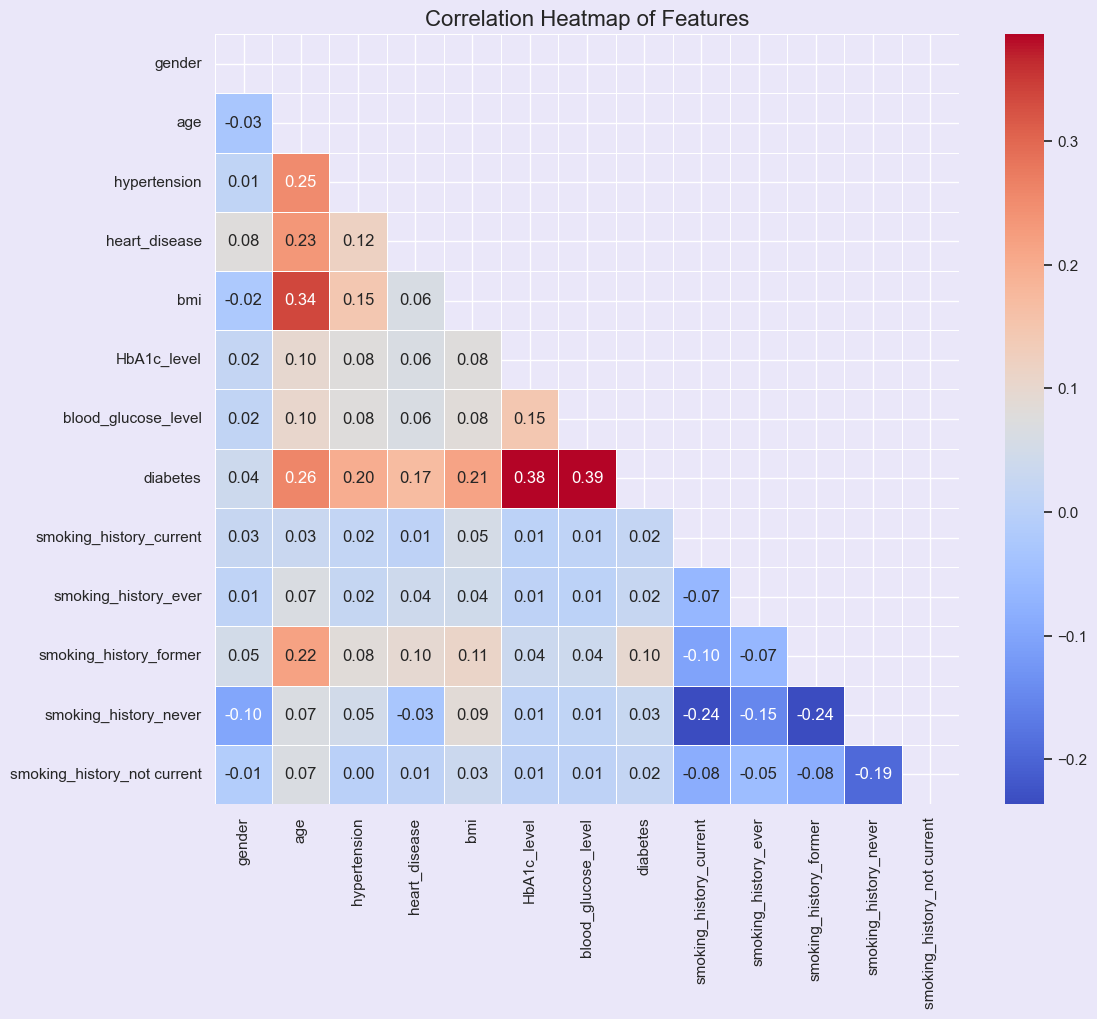

Features with high correlation to diabetes:
age                    0.258008
bmi                    0.214357
HbA1c_level            0.384753
blood_glucose_level    0.386446
diabetes               1.000000
Name: diabetes, dtype: float64


In [70]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=.5)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

# High Correlation Features
high_corr = corr_matrix['diabetes'][abs(corr_matrix['diabetes']) > 0.2]
print("Features with high correlation to diabetes:")
print(high_corr)

In [71]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('diabetes', axis=1))
X = pd.DataFrame(scaled_features, columns=df.columns[:-1])
y = df['diabetes']


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [73]:
log_reg = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200)
log_reg.fit(X_train, y_train)

# Predictions
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluation
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Logistic Regression Training Accuracy: {train_accuracy:.2f}")
print(f"Logistic Regression Validation Accuracy: {test_accuracy:.2f}")


Logistic Regression Training Accuracy: 0.96
Logistic Regression Validation Accuracy: 0.96


In [74]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_train_rf_pred = rf.predict(X_train)
y_test_rf_pred = rf.predict(X_test)

# Evaluation
rf_train_accuracy = accuracy_score(y_train, y_train_rf_pred)
rf_test_accuracy = accuracy_score(y_test, y_test_rf_pred)

print(f"Random Forest Training Accuracy: {rf_train_accuracy:.2f}")
print(f"Random Forest Validation Accuracy: {rf_test_accuracy:.2f}")


Random Forest Training Accuracy: 1.00
Random Forest Validation Accuracy: 0.97


In [75]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                              param_grid_rf, 
                              cv=5, 
                              scoring='accuracy', 
                              verbose=1)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

# Predictions with the best model
y_train_best_rf_pred = best_rf.predict(X_train)
y_test_best_rf_pred = best_rf.predict(X_test)

# Evaluation
best_rf_train_accuracy = accuracy_score(y_train, y_train_best_rf_pred)
best_rf_test_accuracy = accuracy_score(y_test, y_test_best_rf_pred)

print(f"Best Random Forest Training Accuracy: {best_rf_train_accuracy:.2f}")
print(f"Best Random Forest Validation Accuracy: {best_rf_test_accuracy:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Training Accuracy: 0.97
Best Random Forest Validation Accuracy: 0.97


In [76]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_train_dt_pred = dt.predict(X_train)
y_test_dt_pred = dt.predict(X_test)

# Evaluation
dt_train_accuracy = accuracy_score(y_train, y_train_dt_pred)
dt_test_accuracy = accuracy_score(y_test, y_test_dt_pred)

print(f"Decision Tree Training Accuracy: {dt_train_accuracy:.2f}")
print(f"Decision Tree Validation Accuracy: {dt_test_accuracy:.2f}")


Decision Tree Training Accuracy: 1.00
Decision Tree Validation Accuracy: 0.95


In [77]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              param_grid_dt, 
                              cv=5, 
                              scoring='accuracy', 
                              verbose=1)

grid_search_dt.fit(X_train, y_train)

best_dt = grid_search_dt.best_estimator_

# Predictions with the best model
y_train_best_dt_pred = best_dt.predict(X_train)
y_test_best_dt_pred = best_dt.predict(X_test)

# Evaluation
best_dt_train_accuracy = accuracy_score(y_train, y_train_best_dt_pred)
best_dt_test_accuracy = accuracy_score(y_test, y_test_best_dt_pred)

print(f"Best Decision Tree Training Accuracy: {best_dt_train_accuracy:.2f}")
print(f"Best Decision Tree Validation Accuracy: {best_dt_test_accuracy:.2f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Decision Tree Training Accuracy: 0.97
Best Decision Tree Validation Accuracy: 0.97


In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_train_knn_pred = knn.predict(X_train)
y_test_knn_pred = knn.predict(X_test)

# Evaluation
knn_train_accuracy = accuracy_score(y_train, y_train_knn_pred)
knn_test_accuracy = accuracy_score(y_test, y_test_knn_pred)

print(f"KNN Training Accuracy: {knn_train_accuracy:.2f}")
print(f"KNN Validation Accuracy: {knn_test_accuracy:.2f}")


KNN Training Accuracy: 0.97
KNN Validation Accuracy: 0.96


In [79]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), 
                               param_grid_knn, 
                               cv=5, 
                               scoring='accuracy', 
                               verbose=1)

grid_search_knn.fit(X_train, y_train)

best_knn = grid_search_knn.best_estimator_

# Predictions with the best model
y_train_best_knn_pred = best_knn.predict(X_train)
y_test_best_knn_pred = best_knn.predict(X_test)

# Evaluation
best_knn_train_accuracy = accuracy_score(y_train, y_train_best_knn_pred)
best_knn_test_accuracy = accuracy_score(y_test, y_test_best_knn_pred)

print(f"Best KNN Training Accuracy: {best_knn_train_accuracy:.2f}")
print(f"Best KNN Validation Accuracy: {best_knn_test_accuracy:.2f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best KNN Training Accuracy: 0.97
Best KNN Validation Accuracy: 0.96


In [80]:
svc = SVC(kernel='linear', probability=True, random_state=42)
svc.fit(X_train, y_train)

# Predictions
y_train_svc_pred = svc.predict(X_train)
y_test_svc_pred = svc.predict(X_test)

# Evaluation
svc_train_accuracy = accuracy_score(y_train, y_train_svc_pred)
svc_test_accuracy = accuracy_score(y_test, y_test_svc_pred)

print(f"SVC Training Accuracy: {svc_train_accuracy:.2f}")
print(f"SVC Validation Accuracy: {svc_test_accuracy:.2f}")


SVC Training Accuracy: 0.96
SVC Validation Accuracy: 0.96


In [81]:
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)

# Predictions
y_train_ada_pred = ada.predict(X_train)
y_test_ada_pred = ada.predict(X_test)

# Evaluation
ada_train_accuracy = accuracy_score(y_train, y_train_ada_pred)
ada_test_accuracy = accuracy_score(y_test, y_test_ada_pred)

print(f"AdaBoost Training Accuracy: {ada_train_accuracy:.2f}")
print(f"AdaBoost Validation Accuracy: {ada_test_accuracy:.2f}")


AdaBoost Training Accuracy: 0.97
AdaBoost Validation Accuracy: 0.97


In [82]:
gbm = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

# Predictions
y_train_gbm_pred = gbm.predict(X_train)
y_test_gbm_pred = gbm.predict(X_test)

# Evaluation
gbm_train_accuracy = accuracy_score(y_train, y_train_gbm_pred)
gbm_test_accuracy = accuracy_score(y_test, y_test_gbm_pred)

print(f"Gradient Boosting Training Accuracy: {gbm_train_accuracy:.2f}")
print(f"Gradient Boosting Validation Accuracy: {gbm_test_accuracy:.2f}")


Gradient Boosting Training Accuracy: 0.97
Gradient Boosting Validation Accuracy: 0.97


In [83]:
xgb = XGBClassifier(n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_train_xgb_pred = xgb.predict(X_train)
y_test_xgb_pred = xgb.predict(X_test)

# Evaluation
xgb_train_accuracy = accuracy_score(y_train, y_train_xgb_pred)
xgb_test_accuracy = accuracy_score(y_test, y_test_xgb_pred)

print(f"XGBoost Training Accuracy: {xgb_train_accuracy:.2f}")
print(f"XGBoost Validation Accuracy: {xgb_test_accuracy:.2f}")


XGBoost Training Accuracy: 0.97
XGBoost Validation Accuracy: 0.97


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve)

In [95]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)[:,1]
    else:
        # For models like SVC without predict_proba
        y_test_prob = model.decision_function(X_test)
    # Metrics Calculation
    metrics_dict = {
        'Model': model_name,
        'Training Accuracy': accuracy_score(y_train, y_train_pred),
        'Validation Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_test_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_test_prob)
    }
    # Print Metrics
    print(f"--- {model_name} ---")
    for metric, value in metrics_dict.items():
        if metric != 'Model':
            print(f"{metric}: {value:.2f}")
    print("\n")
    # Confusion Matrix
    cf = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_test_prob):.2f})')
    plt.plot([0,1], [0,1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return metrics_dict

--- Logistic Regression ---
Training Accuracy: 0.96
Validation Accuracy: 0.96
Precision: 0.84
Recall: 0.63
F1-Score: 0.72
ROC-AUC: 0.96




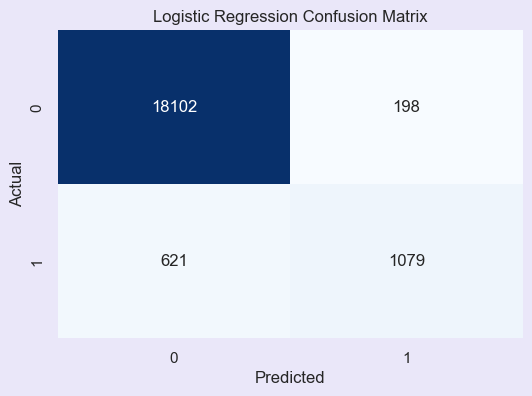

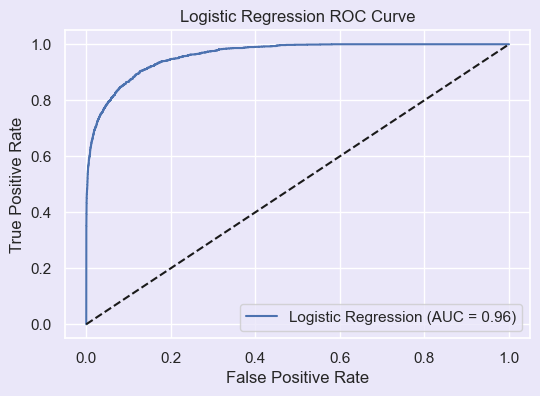

--- Random Forest ---
Training Accuracy: 0.97
Validation Accuracy: 0.97
Precision: 0.99
Recall: 0.68
F1-Score: 0.81
ROC-AUC: 0.97




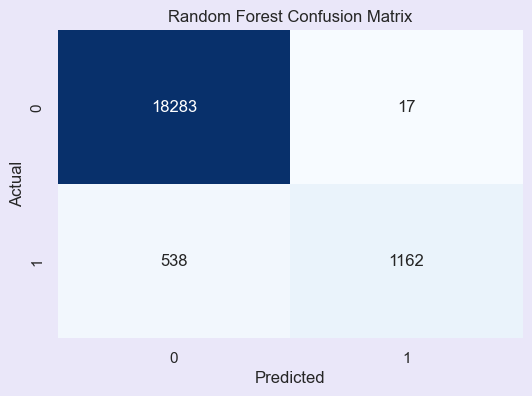

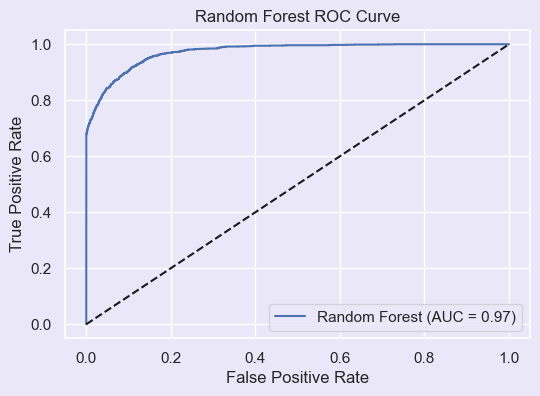

--- Decision Tree ---
Training Accuracy: 0.97
Validation Accuracy: 0.97
Precision: 1.00
Recall: 0.67
F1-Score: 0.81
ROC-AUC: 0.95




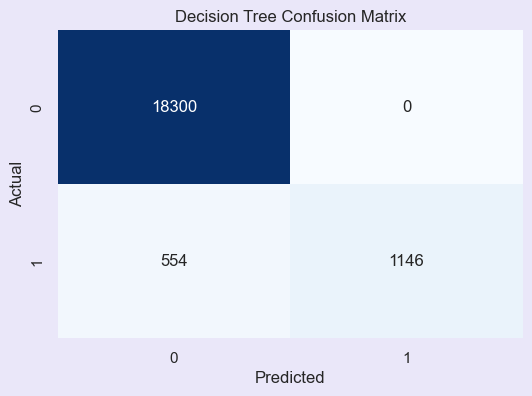

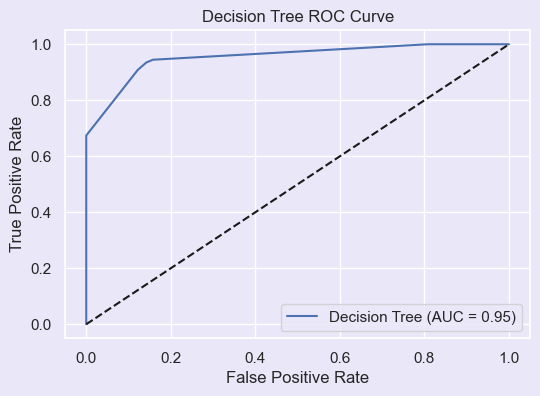

--- K-Nearest Neighbors ---
Training Accuracy: 0.97
Validation Accuracy: 0.96
Precision: 0.94
Recall: 0.59
F1-Score: 0.73
ROC-AUC: 0.93




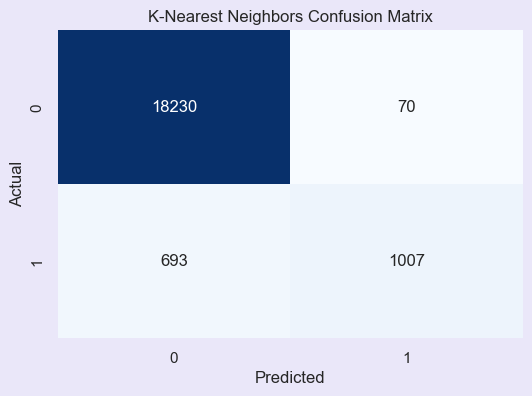

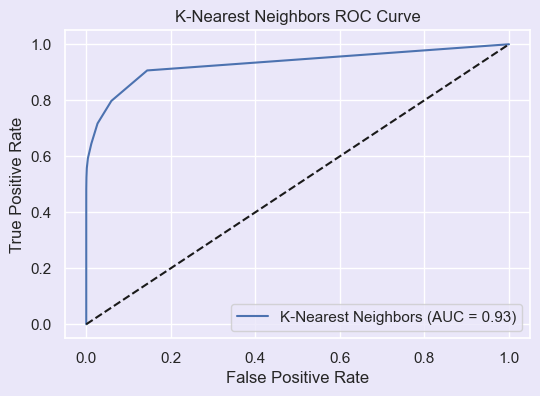

--- Support Vector Classifier ---
Training Accuracy: 0.96
Validation Accuracy: 0.96
Precision: 0.89
Recall: 0.61
F1-Score: 0.72
ROC-AUC: 0.96




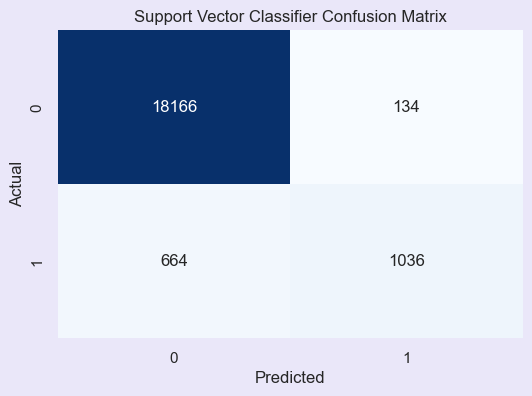

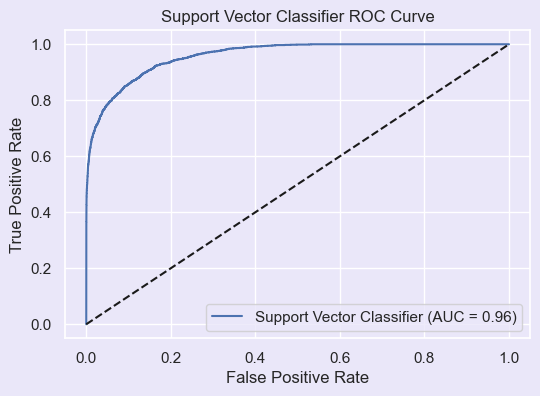

--- AdaBoost ---
Training Accuracy: 0.97
Validation Accuracy: 0.97
Precision: 0.97
Recall: 0.69
F1-Score: 0.81
ROC-AUC: 0.98




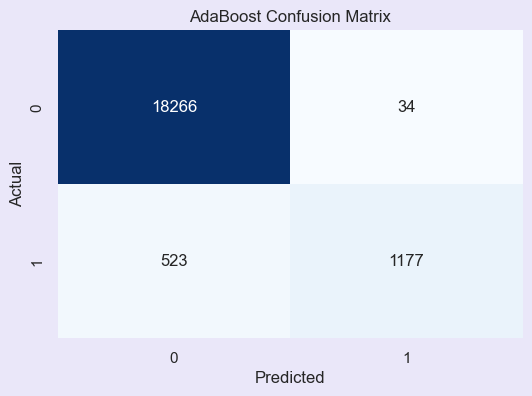

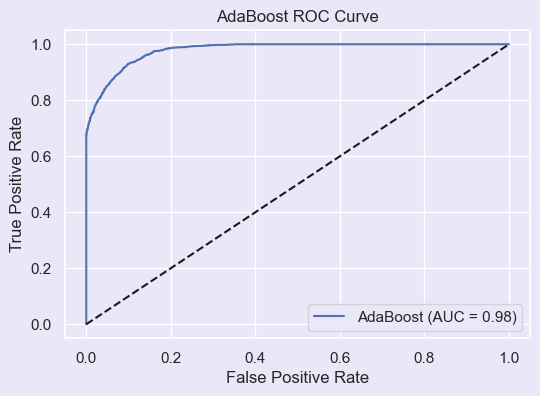

--- Gradient Boosting ---
Training Accuracy: 0.97
Validation Accuracy: 0.97
Precision: 0.98
Recall: 0.69
F1-Score: 0.81
ROC-AUC: 0.98




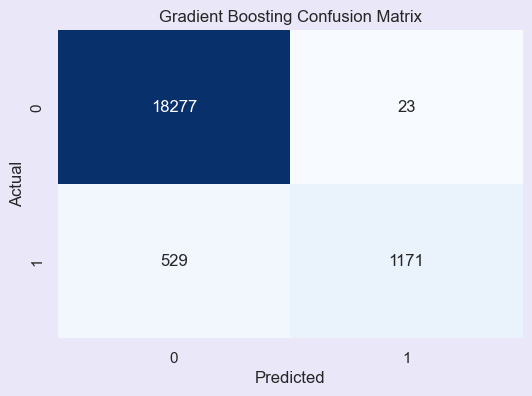

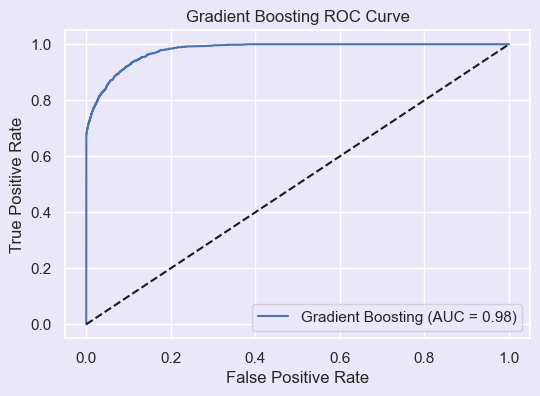

--- XGBoost ---
Training Accuracy: 0.97
Validation Accuracy: 0.97
Precision: 0.98
Recall: 0.69
F1-Score: 0.81
ROC-AUC: 0.98




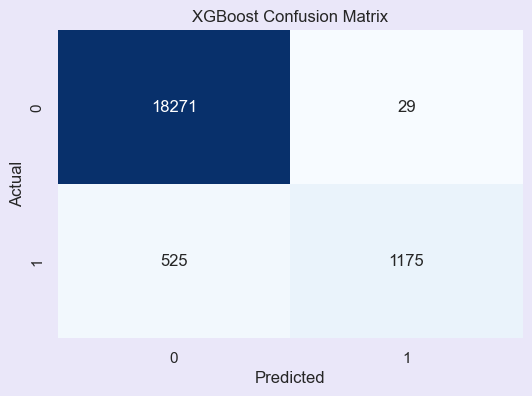

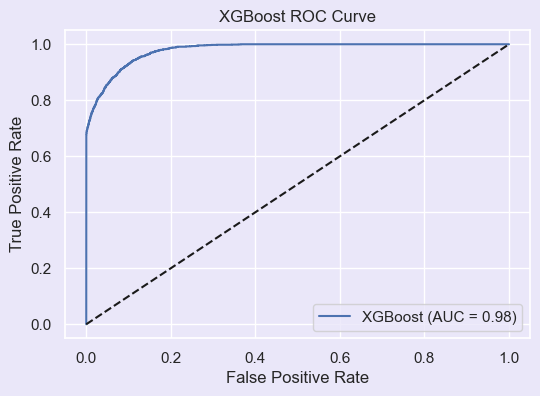

In [96]:
# List to store metrics for all models
model_metrics = []
# Logistic Regression
metrics_logreg = evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")
model_metrics.append(metrics_logreg)
# Random Forest
metrics_rf = evaluate_model(best_rf, X_train, y_train, X_test, y_test, "Random Forest")
model_metrics.append(metrics_rf)
# Decision Tree
metrics_dt = evaluate_model(best_dt, X_train, y_train, X_test, y_test, "Decision Tree")
model_metrics.append(metrics_dt)
# K-Nearest Neighbors
metrics_knn = evaluate_model(best_knn, X_train, y_train, X_test, y_test, "K-Nearest Neighbors")
model_metrics.append(metrics_knn)
# Support Vector Classifier
metrics_svc = evaluate_model(svc, X_train, y_train, X_test, y_test, "Support Vector Classifier")
model_metrics.append(metrics_svc)
# AdaBoost
metrics_ada = evaluate_model(ada, X_train, y_train, X_test, y_test, "AdaBoost")
model_metrics.append(metrics_ada)
# Gradient Boosting
metrics_gbm = evaluate_model(gbm, X_train, y_train, X_test, y_test, "Gradient Boosting")
model_metrics.append(metrics_gbm)
# XGBoost
metrics_xgb = evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost")
model_metrics.append(metrics_xgb)


In [97]:
import pandas as pd

# Convert the list of metrics dictionaries into a DataFrame
metrics_df = pd.DataFrame(model_metrics)

# Reorder the columns for better readability
metrics_df = metrics_df[['Model', 'Training Accuracy', 'Validation Accuracy', 
                         'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

# Display the DataFrame with styling
styled_metrics_df = metrics_df.style.set_properties(**{
    'background-color': '#F5F5F5',
    'color': '#333333',
    'border': '1px solid black',
    'padding': '8px',
    'text-align': 'center'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('background-color', '#254E58'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '8px')
        ]
    }
])

styled_metrics_df


,Model,Training Accuracy,Validation Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.959075,0.959050,0.844949,0.634706,0.724891,0.961797
1,Random Forest,0.974600,0.972250,0.985581,0.683529,0.807225,0.973313
2,Decision Tree,0.971762,0.972300,1.000000,0.674118,0.805341,0.954053
3,K-Nearest Neighbors,0.966600,0.961850,0.935005,0.592353,0.725243,0.930015
4,Support Vector Classifier,0.960237,0.960100,0.885470,0.609412,0.721951,0.959862
5,AdaBoost,0.971912,0.972150,0.971924,0.692353,0.808657,0.979158
6,Gradient Boosting,0.972337,0.972400,0.980737,0.688824,0.809261,0.979100
7,XGBoost,0.972625,0.972300,0.975914,0.691176,0.809229,0.979804


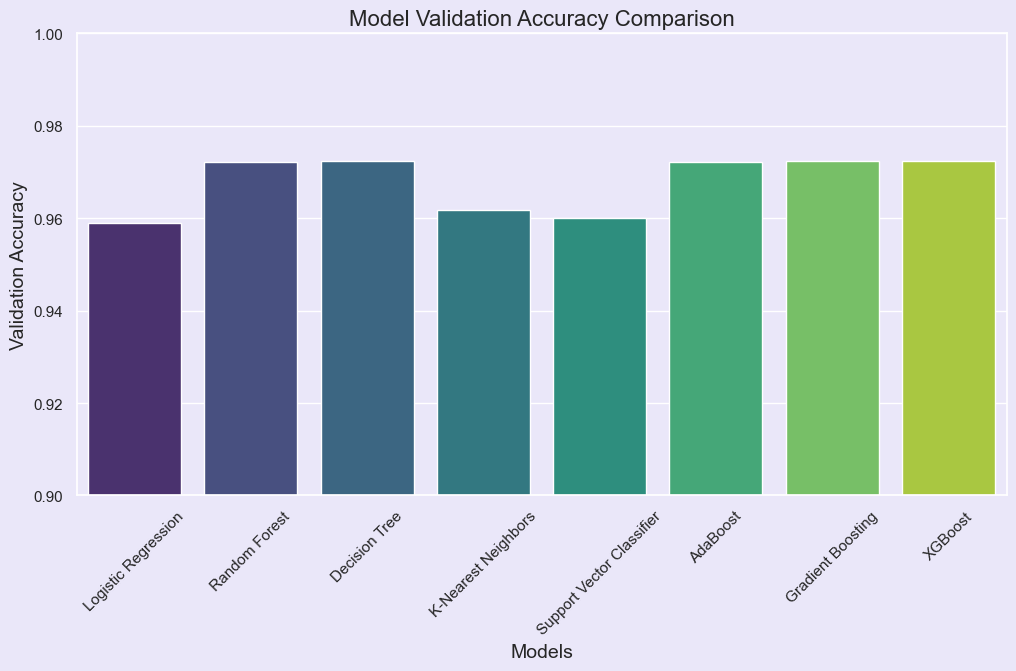

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with your metrics
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 
              'K-Nearest Neighbors', 'Support Vector Classifier', 
              'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'Validation Accuracy': [0.959050, 0.972250, 0.972300, 
                            0.961850, 0.960100, 
                            0.972150, 0.972400, 0.972300]
}

metrics_df = pd.DataFrame(data)

plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Validation Accuracy', data=metrics_df, palette='viridis')
plt.ylim(0.90, 1.00)
plt.title('Model Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.xticks(rotation=45)
plt.show()
